In [78]:
# import necessary libraries

import pandas as pd
import numpy as np
import missingno as msno 
import seaborn as sns
import matplotlib.pyplot as plt 

#sklearn

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score

#imbalanced learning


# import custom functions
from custom_functions import get_data_summary, our_metrics, eval_metrics#, evaluate_model

# import custom scorers
#from custom_functions import get_f15, get_f2, get_f3



# import warnings
# warnings.filterwarnings('ignore')

In [79]:
# loading the data
# this contains all the numerical (unscaled) and dummies from categorical
df = pd.read_csv('data/df_processed_dmy.csv')

# this contains the training dataset including a column with target predictions by the model
df_predictions = pd.read_csv('data/df_test.csv')

# Plot of Target Distribution by Counter Category

In [80]:
# Mapping 0 and 1 to strings 'Gaz and Electricity

df['counter_type_GAZ'] = df['counter_type_GAZ'].map({
    0: 'Electricity',
    1: 'Gaz', 
    })
df['counter_type_GAZ'].unique()

array(['Electricity', 'Gaz'], dtype=object)

In [81]:
# Set custom color palette
# from https://coolors.co/

colors = ['#2c1258','#b86a44'#, '#671f47', '#a22e54',  '#dabc66'
          ]
customPalette = sns.set_palette(sns.color_palette(colors))
sns.set_style("darkgrid")

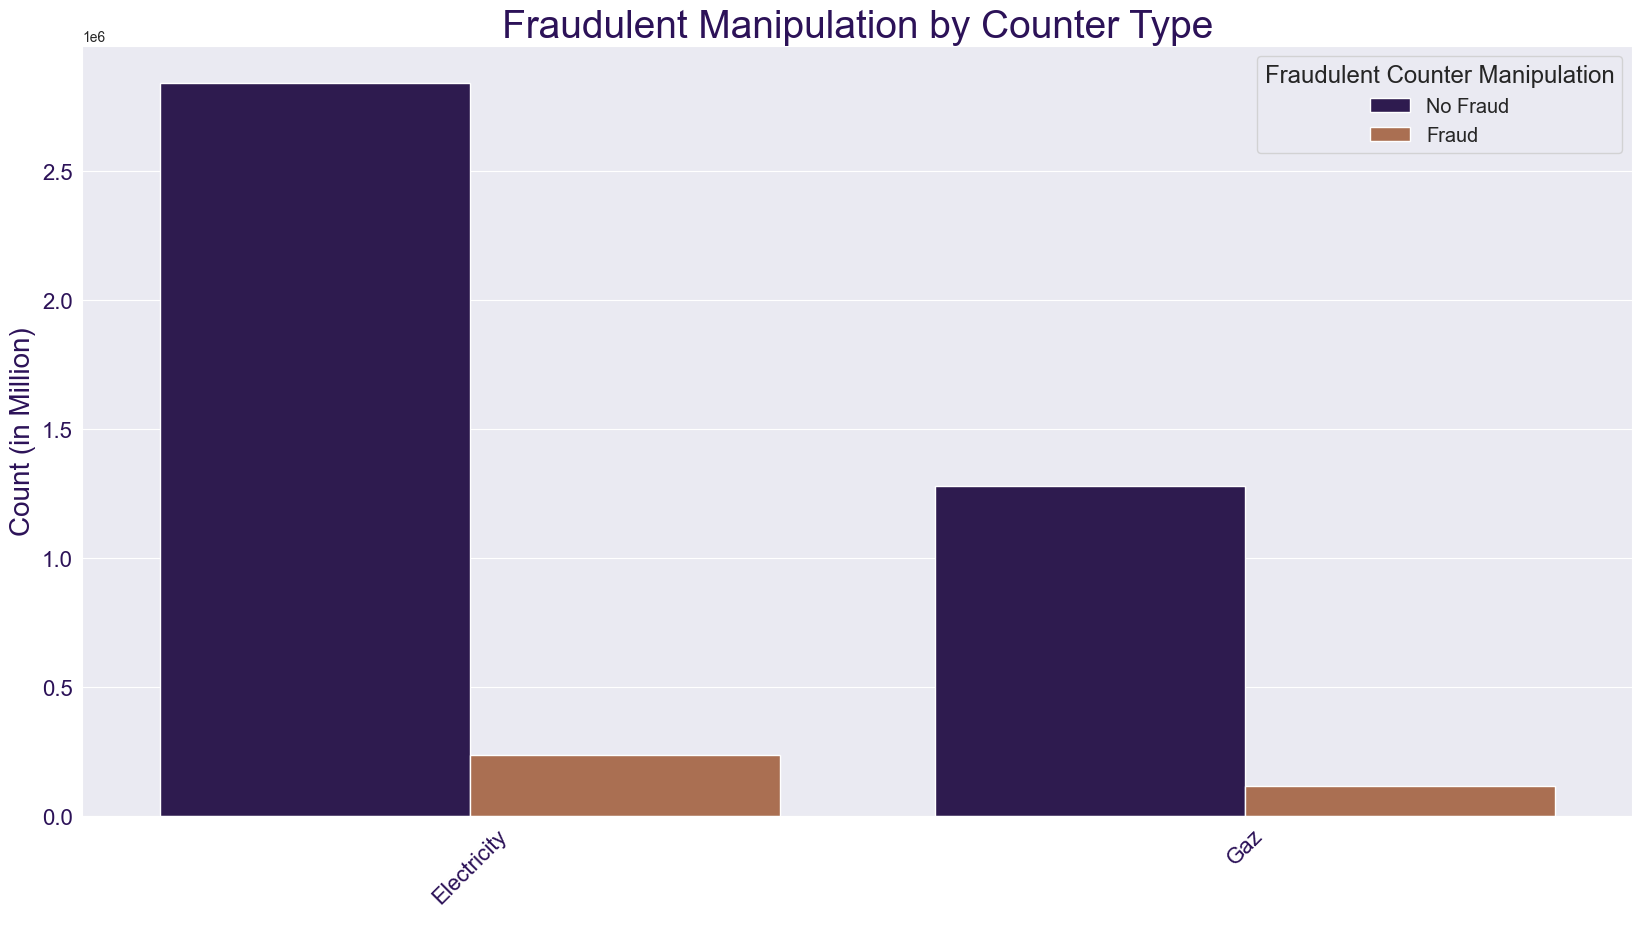

In [82]:
# plot countplot of target distribution by counter category

fig = plt.figure(figsize=(20,10))
g = sns.countplot(data=df, x='counter_type_GAZ', hue='target', color=customPalette)

plt.xticks(rotation=45)
plt.legend(
    title='Fraudulent Counter Manipulation',
    labels = ['No Fraud','Fraud'],
    fontsize='x-large',
    title_fontsize='xx-large')
plt.xlabel(' ');
plt.ylabel('Count (in Million)', fontsize=20, color='#2c1258');
plt.title('Fraudulent Manipulation by Counter Type', fontsize=28, color='#2c1258')
plt.xticks(color='#2c1258',fontsize=16)
plt.yticks(color='#2c1258', fontsize=16)
#plt.savefig('plots/target_distribution.jpg')
plt.show();


# Plot of Correct Detections by Counter Category

In [83]:
df_predictions.head()

,member_years,index_change_month,quantity_counters,client_catg_11,client_catg_12,client_catg_51,region_101,region_103,region_104,region_105,...,reading_remarque_7,reading_remarque_8,reading_remarque_9,counter_type_ELEC,counter_type_GAZ,target,fraud_pred,no_fraud_proba,fraud_proba,pred_corr
0,11,17.000,58,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0.499381,0.500619,False
1,5,20.375,68,1,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0.496718,0.503282,False
2,4,0.000,48,0,0,1,0,0,1,0,...,0,0,0,0,1,0,1,0.498331,0.501669,False
3,28,415.500,62,1,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0.499155,0.500845,False
4,20,5.750,60,1,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0.495342,0.504658,False


In [84]:
# subset of data only holding correct predictions (true positives and true negatives)
df_correct_predictions = df_predictions.query('pred_corr == True')
df_correct_predictions.head(20)

,member_years,index_change_month,quantity_counters,client_catg_11,client_catg_12,client_catg_51,region_101,region_103,region_104,region_105,...,reading_remarque_7,reading_remarque_8,reading_remarque_9,counter_type_ELEC,counter_type_GAZ,target,fraud_pred,no_fraud_proba,fraud_proba,pred_corr
5,1,18.250,34,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0.500782,0.499218,True
6,14,30.500,80,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.503207,0.496793,True
8,21,30.750,72,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.502280,0.497720,True
9,0,98.250,25,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0.501935,0.498065,True
10,31,127.250,38,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0.502703,0.497297,True
12,10,14.750,80,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.500663,0.499337,True
13,9,543.000,36,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0.502187,0.497813,True
16,20,125.375,57,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0.500706,0.499294,True
17,6,303.500,41,1,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0.504041,0.495959,True
18,18,98.000,41,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0.500249,0.499751,True


In [85]:
# Mapping 0 and 1 to strings 'Gaz' and 'Electricity'

df_correct_predictions['counter_type_GAZ'] = df_correct_predictions['counter_type_GAZ'].map({
    1: 'Electricity',
    0: 'Gaz' 
    })
df_correct_predictions['counter_type_GAZ'].unique()

/var/folders/0r/8xzhnvk55wbfn1wf1m61sm5h0000gn/T/ipykernel_1446/2777914202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correct_predictions['counter_type_GAZ'] = df_correct_predictions['counter_type_GAZ'].map({


array(['Electricity', 'Gaz'], dtype=object)

In [86]:
df_correct_predictions['counter_type_GAZ'].unique()

array(['Electricity', 'Gaz'], dtype=object)

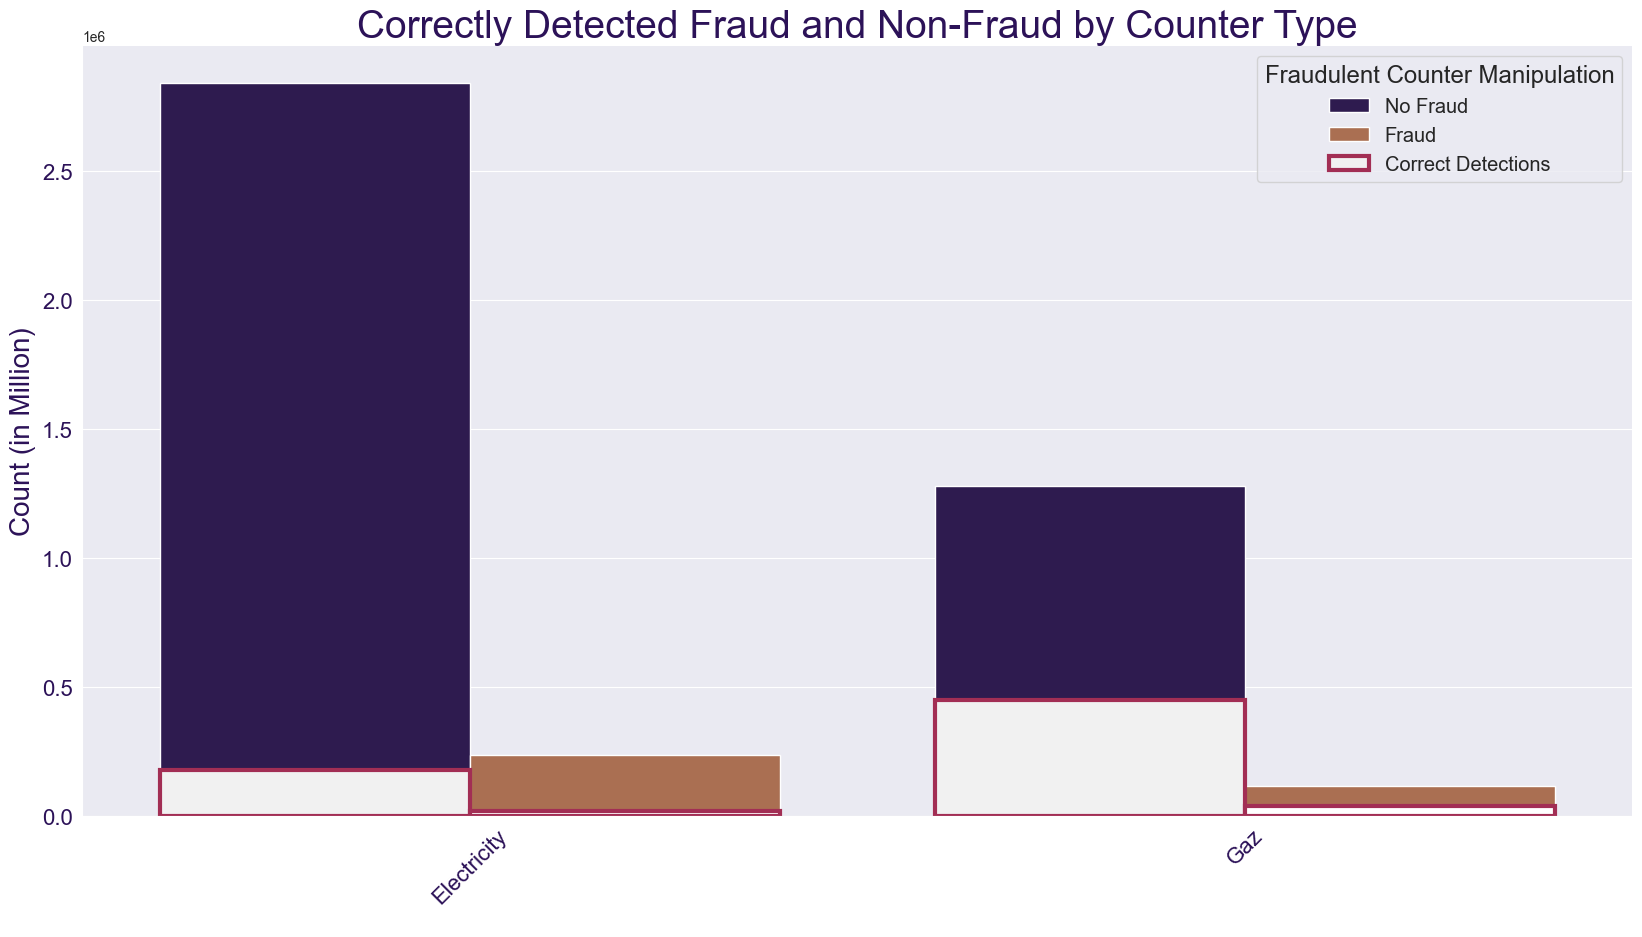

In [90]:

fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(ax = ax, data=df, x='counter_type_GAZ', hue='target', color=customPalette)

sns.countplot(ax = ax, data=df_correct_predictions, x='counter_type_GAZ', hue='target', color='w', edgecolor='#a22e54', linewidth=3)


sns.set_style("darkgrid")
sns.despine()

ax.set_title('Correctly Detected Fraud and Non-Fraud by Counter Type', fontsize=28, color='#2c1258')
ax.set_ylabel('Count (in Million)', fontsize=20, color='#2c1258')
ax.set_xlabel(' ')
plt.xticks(rotation=45)
plt.xticks(color='#2c1258',fontsize=16)
plt.yticks(color='#2c1258', fontsize=16)

ax.legend(
    title='Fraudulent Counter Manipulation',
    labels = ['No Fraud','Fraud', 'Correct Detections'],
    fontsize='x-large',
    title_fontsize='xx-large')

plt.savefig("plots/model_results.jpg");